# This code performs variable reduction via the ClustOfVar package in order to identify the most representative / least collinear covariates sampled from the point locations

## Load the necessary libraries and the raw data

In [1]:
# Load the libraries without any messages
suppressMessages(library(ClustOfVar))
suppressMessages(library(tictoc))
suppressMessages(library(tidyverse))
suppressMessages(library(jsonlite))
suppressMessages(library(caret))

# Input the file path of the raw data CSV as a string
filePath = '20180706_NematodePoints_SampledPixelValues.csv'

# Inspect the data
nematodeData = read.csv(file=filePath, header=TRUE)
str(nematodeData)

'data.frame':	1874 obs. of  87 variables:
 $ system.index                       : Factor w/ 1874 levels "0000001a97eae3c6e448",..: 394 12 1324 226 1714 207 1396 969 219 1838 ...
 $ Abs_Lat                            : num  22.4 22 21.3 21.3 21.4 ...
 $ Annual_Mean_Radiation              : num  140 143 153 151 150 ...
 $ Annual_Mean_Temperature            : num  18.1 19 19.7 19.5 18.9 ...
 $ Annual_Precipitation               : num  1519 1528 1614 1619 1616 ...
 $ Aridity_Index                      : num  10354 9590 10367 10575 10974 ...
 $ Bacterivor                         : num  120 45 390 224 40 60 70 39 15 40 ...
 $ Bulk_Density_15cm                  : num  1236 1283 1334 1317 1239 ...
 $ CContent_15cm                      : num  25 27 19 17 27 16 35 19 20 23 ...
 $ CatIonExcCap_15cm                  : num  12 9 7 7 8 8 9 9 8 8 ...
 $ Clay_Content_15cm                  : num  34 40 37 36 35 33 38 39 43 42 ...
 $ CoOfVar_EVI_Hetero_1km             : num  445 285 676 1020 2026 ...
 $

### Isolate the covariate data without any of the dependent variables

In [2]:
# Make an independent copy of the covariate data
covariateDF = subset(nematodeData,select=-c(system.index,
                                            Bacterivor,
                                            Fungivores,
                                            Omnivores,
                                            Plant_feed,
                                            Predators,
                                            Unidentifi,
                                            Pixel_Lat,
                                            Pixel_Long,
                                            Lai,
                                            Fpar,
                                            .geo))

print('Covariate Variable Names')
print(colnames(covariateDF))

[1] "Covariate Variable Names"
 [1] "Abs_Lat"                             "Annual_Mean_Radiation"              
 [3] "Annual_Mean_Temperature"             "Annual_Precipitation"               
 [5] "Aridity_Index"                       "Bulk_Density_15cm"                  
 [7] "CContent_15cm"                       "CatIonExcCap_15cm"                  
 [9] "Clay_Content_15cm"                   "CoOfVar_EVI_Hetero_1km"             
[11] "Contrast_EVI_Hetero_1km"             "CorFragVolPerc_15cm"                
[13] "Correlation_EVI_Hetero_1km"          "Depth_to_Bedrock"                   
[15] "Dissimilarity_EVI_Hetero_1km"        "EVI"                                
[17] "Entropy_EVI_Hetero_1km"              "Evenness_EVI_Hetero_1km"            
[19] "Global_Biomass_IPCC"                 "Gpp"                                
[21] "Highest_Weekly_Radiation"            "Homogeneity_EVI_Hetero_1km"         
[23] "Human_Development"                   "Isothermality"                    

In [3]:
# Examine the number of NA's
numberOfNAs = sapply(covariateDF, function(y) sum(length(which(is.na(y)))))
numberOfNAs = data.frame(numberOfNAs)
print(numberOfNAs)

                                    numberOfNAs
Abs_Lat                                       0
Annual_Mean_Radiation                         1
Annual_Mean_Temperature                       0
Annual_Precipitation                          0
Aridity_Index                                 0
Bulk_Density_15cm                             0
CContent_15cm                                 0
CatIonExcCap_15cm                             0
Clay_Content_15cm                             0
CoOfVar_EVI_Hetero_1km                        0
Contrast_EVI_Hetero_1km                       0
CorFragVolPerc_15cm                           0
Correlation_EVI_Hetero_1km                    0
Depth_to_Bedrock                              0
Dissimilarity_EVI_Hetero_1km                  0
EVI                                           0
Entropy_EVI_Hetero_1km                        0
Evenness_EVI_Hetero_1km                       0
Global_Biomass_IPCC                           0
Gpp                                     

In [4]:
# Examine how many points contain NA values
pointsWithNAs = covariateDF[!complete.cases(covariateDF),]
dim(pointsWithNAs)

[1]  7 75

In [5]:
# Make a dataset with only complete data
completeData = covariateDF[complete.cases(covariateDF),]
dim(completeData)

[1] 1867   75

### Discern how the variables trend and choose the top variables from each cluster (specifying multiple numbers of clusters to test)

In [6]:
# Subset the covariate data for clustering
dataToCluster = subset(completeData,select=-c(Total_Numb))

In [7]:
# Examine the dimensions of the data to cluster
dim(dataToCluster)

[1] 1867   74

4.657 sec elapsed


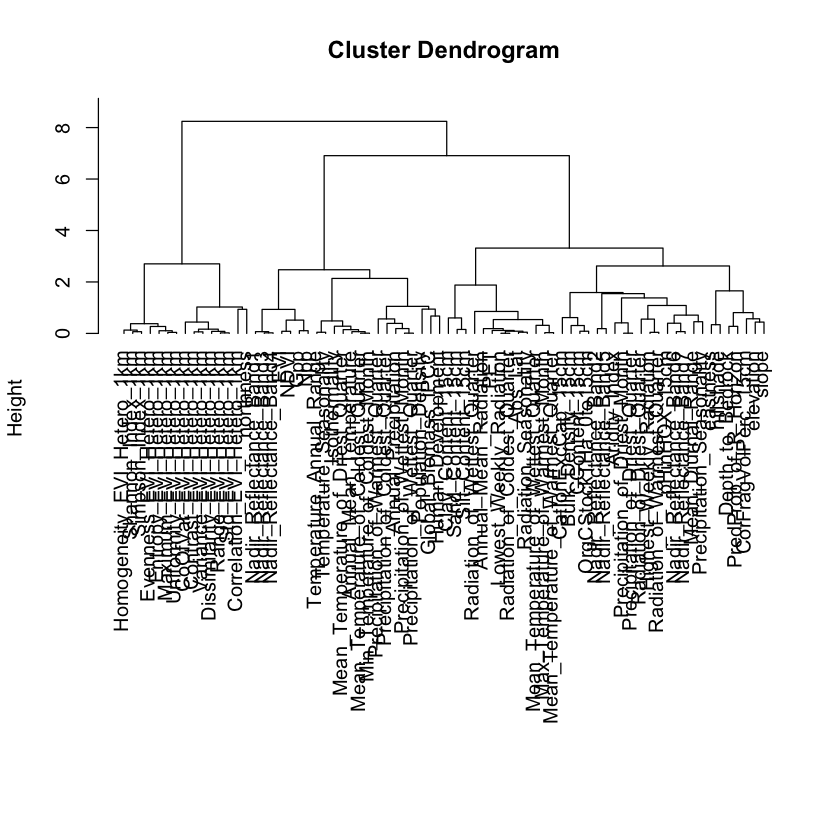

In [8]:
tic()

# Run the clustering function and plot the variables
tree = hclustvar(X.quanti=dataToCluster)
plot(tree)

toc()

In [9]:
# Enter desired number of clusters to generate (in a vector)
numOfClusters = c(5,10,15,20,25)

In [10]:
# Prep an empy list to store the variables from the clustering
emptyVarsList = list()


# Loop the clustering across the desired number of clusters
for (nC in numOfClusters){
    
    # Set the random number seed
    set.seed(42)

    # Examine the top variables in each cluster
    part = cutreevar(tree,nC)

    # Instantiate an empty list in which to store the variables
    midVariableList = c()

    # Extract only the names of the variables (i.e., unlist the values in their parent data structure)
    namesListWithNulls = lapply(part$var,rownames)
    namesListWithoutNulls = Filter(Negate(function(x) is.null(unlist(x))), namesListWithNulls)

    # Ascertain the top variables from the KMeans Clustering
    # and store it in a list
    for (j in c(1:length(namesListWithoutNulls))){
        midVariableList[j] = namesListWithoutNulls[[j]][1]
    }

    # Prep the variable list for input into the model calls
    varsToInclude = list((midVariableList))
    emptyVarsList[match(nC,numOfClusters)] = varsToInclude

    }
print(emptyVarsList)

[[1]]
[1] "Lowest_Weekly_Radiation"          "Min_Temperature_of_Coldest_Month"
[3] "Nadir_Reflectance_Band7"          "Std_EVI_Hetero_1km"              
[5] "Simpson_Index_1km"               

[[2]]
 [1] "Lowest_Weekly_Radiation"          "Min_Temperature_of_Coldest_Month"
 [3] "Precipitation_of_Wettest_Quarter" "Nadir_Reflectance_Band7"         
 [5] "Sand_Content_15cm"                "Std_EVI_Hetero_1km"              
 [7] "PredProb_of_R_Horizon"            "Nadir_Reflectance_Band1"         
 [9] "Simpson_Index_1km"                "hillshade"                       

[[3]]
 [1] "Lowest_Weekly_Radiation"          "Min_Temperature_of_Coldest_Month"
 [3] "Precipitation_of_Wettest_Quarter" "Precipitation_of_Driest_Quarter" 
 [5] "OrgCStockTHa_0to15cm"             "Sand_Content_15cm"               
 [7] "Std_EVI_Hetero_1km"               "PredProb_of_R_Horizon"           
 [9] "Nadir_Reflectance_Band1"          "Simpson_Index_1km"               
[11] "Human_Development"                "Ra

In [11]:
# Export the results to a JSON file or a CSV
variableDataFrame = as.data.frame(cbind(numOfClusters,emptyVarsList))
variableDataFrame

numOfClusters
1 5            
2 10           
3 15           
4 20           
5 25           
  emptyVarsList                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
1 Lowest_Weekly_Radiation         , Min_Temperature_of_Coldest_Month, Nadir_Reflectance_Band7         , Std_EVI_Hetero_1km              , Simpson_Index_1km                                                                                                                                                                                                                                                                                                                                                                                                                                       
2 Lowest_Weekly_Radiation         , Min_Temperature_of_Coldest_Month, Precipitation_of_Wettest_Quarter, Nadir_Reflectance_Band7         , Sand_Content_15cm               , Std_EVI_Hetero_1km              , PredProb_of_R_Horizon           , Nadir_Reflectance_Band1         , Simpson_Index_1km               , hillshade                                                                                                                                                                                                                                                                     
3 Lowest_Weekly_Radiation         , Min_Temperature_of_Coldest_Month, Precipitation_of_Wettest_Quarter, Precipitation_of_Driest_Quarter , OrgCStockTHa_0to15cm            , Sand_Content_15cm               , Std_EVI_Hetero_1km              , PredProb_of_R_Horizon           , Nadir_Reflectance_Band1         , Simpson_Index_1km               , Human_Development               , Radiation_of_Warmest_Quarter    , Nadir_Reflectance_Band7         , Nadir_Reflectance_Band5         , hillshade                                                                                           
4 Lowest_Weekly_Radiation         , Min_Temperature_of_Coldest_Month, Precipitation_of_Wettest_Quarter, Precipitation_of_Driest_Quarter , OrgCStockTHa_0to15cm            , Sand_Content_15cm               , Std_EVI_Hetero_1km              , PredProb_of_R_Horizon           , NDVI                            , Simpson_Index_1km               , Global_Biomass_IPCC             , Radiation_of_Warmest_Quarter    , Nadir_Reflectance_Band7         , Nadir_Reflectance_Band4         , Nadir_Reflectance_Band5         , hillshade                                                         
5 Lowest_Weekly_Radiation         , Min_Temperature_of_Coldest_Month, Precipitation_of_Wettest_Quarter, Precipitation_of_Driest_Quarter , OrgCStockTHa_0to15cm            , Std_EVI_Hetero_1km              , slope                           , PredProb_of_R_Horizon           , NDVI                            , Simpson_Index_1km               , Radiation_of_Warmest_Quarter    , Precipitation_Seasonality       , Nadir_Reflectance_Band4         , Nadir_Reflectance_Band5         , Nadir_Reflectance_Band7         , Silt_Content_15cm               , hillshade

In [12]:
write_json(variableDataFrame,'20180706_Nematode_Variables_Clustered.json')